In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

In [16]:
import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 14}
mpl.rc('font', **font)

import numpy as np
import pandas as pd

from scipy import stats
import sklearn
import sklearn.cluster
import scprep

In [3]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import louvain
import graphtools as gt

# Comparison of clustering algorithms on toy data

Here we're going to compare three clustering algorithms on toy data. The code for this exercise is adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

### Generating data

Here we're going to work with 6 datasets all in $\mathbb{R}^2$ 

1. **Circles** - two circles, one circumscribed by the other
2. **Moons** - Two interleaving half circles
3. **Varied variance blobs** - These blobs each have different variances
4. **Anisotropically distributed blobs** - these blobs have unequal widths and lengths
5. **Regular blobs** - Just three regular blobs
6. **Uniformly sampled square** - Just a single square

Because we're generating these from scratch, we get to change some parameters of their distributions. Generally, we can change:
1. `noise` - the amount of Gaussian noise added to each point
2. `n_samples` - the number of points generated
3. `factor` / `cluster_std` - some parameters affecting shape

In [4]:
np.random.seed(0)
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

# Circles
noisy_circles = datasets.make_circles(n_samples=n_samples, 
                        # Scale factor between inner and outer circle
                        factor=.5,
                        # Gaussian noise added to each point
                        noise=.05)

# Moons
noisy_moons = datasets.make_moons(n_samples=n_samples, 
                                  noise=.05)

# Blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Uniform square
no_structure = np.random.rand(n_samples, 2), None

# Anisotropically distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
# Changes how x1, x2 coordinates are shifted
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Associate each dataset with the correct # of clusters
# ============

default_base = {'n_clusters': 3}

generated_datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied,      {}),
    (aniso,       {}),
    (blobs, {}),
    (no_structure, {})]

#### Plot ground truth cluster assignments

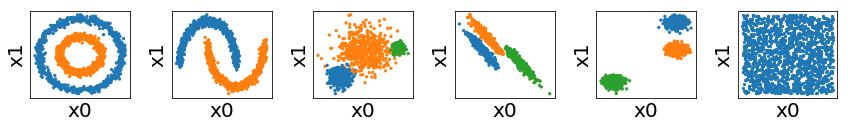

In [17]:
fig, axes = plt.subplots(1,6,figsize=(12,2))

for i, (dataset, _) in enumerate(generated_datasets):
    ax = axes[i]
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    scprep.plot.scatter2d(X, c=y, 
                          ticks=None, ax=ax, 
                          xlabel='x0', ylabel='x1',
                         legend=False)
    
fig.tight_layout()

### Run clustering algorithms and plot results

This is a lot of code, so make sure you and your partner go through and understand what's going on.

/usr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


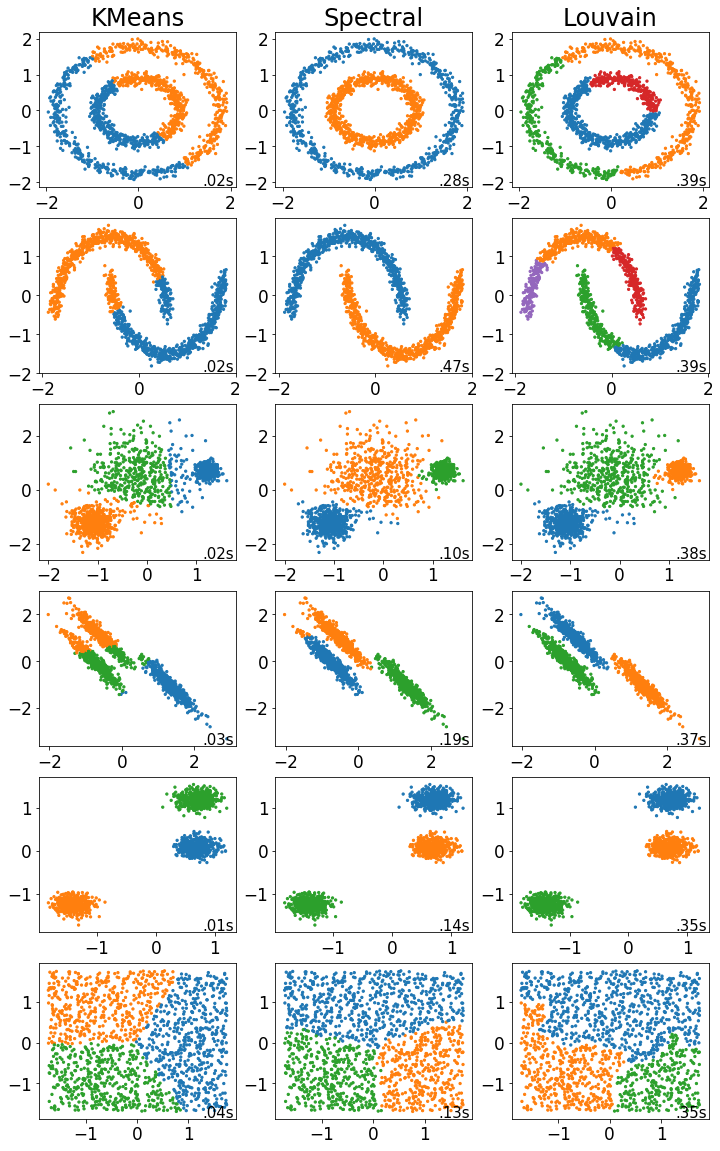

In [18]:
fig, axes = plt.subplots(6,3, figsize=(12, 20))
plot_title = True

for i_dataset, (dataset, cluster_params) in enumerate(generated_datasets):
    # update cluster parameters with dataset-specific values
    params = default_base.copy()
    params.update(cluster_params)

    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
        
    # ============
    # Run clustering algorithms
    # ============
    clusters = []
    titles = []
    times = []
    # KMeans
    tic = time.time()
    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    clusters.append(kmeans.fit_predict(X))
    titles.append('KMeans')
    times.append(time.time() - tic)
    
    # Spectral Clustering
    tic = time.time()
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    clusters.append(spectral.fit_predict(X))
    titles.append('Spectral')
    times.append(time.time() - tic)

    
    # Louvain
    tic = time.time()
    G = gt.Graph(X)
    G_igraph = G.to_igraph()
    part = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                  weights="weight", resolution_parameter=0.01)
    clusters.append(np.array(part.membership))
    titles.append('Louvain')
    times.append(time.time() - tic)

    # ============
    # Plot clustering results for dataset
    # ============
    row_axes = axes[i_dataset]
    
    for i, ax in enumerate(row_axes.flatten()):
        curr_cluster = clusters[i]
        if plot_title:
            curr_title = '{}'.format(titles[i])
        else:
            curr_title = None
            
        scprep.plot.scatter2d(X, c=curr_cluster, title=curr_title, ax=ax,
                             legend=False, discrete=True)

        # Plot time to run algorithm
        plt.text(.99, .01, ('%.2fs' % (times[i])).lstrip('0'),
                 transform=ax.transAxes, size=15,
                 horizontalalignment='right')
    plot_title=False
fig.tight_layout()

#### Discussion
In pairs, change the following features for one or more of the distributions
1. `noise` - the amount of Gaussian noise added to each point
2. `n_samples` - the number of points generated
3. `factor` / `cluster_std` / `transformation` - some parameters affecting shape

Try to identify:
1. A set of parameters that makes `SpectralClustering` fail on the circles dataset
2. `Louvain` fail on the anisotropically distributed blobs
3. `KMeans` fail on the three regular blobs.

# Identifying the correct number of clusters

Although it is possible to visually inspect the data and select an ideal number of clusters, there are several measures for quantitatively selecting the ideal number of partitions for a given dataset. Here, we're going to focus on one measure, called the Silhouette score, which calculates a ratio between the inter- and intra- distances for a given set of cluster assignments. We'll describe that more below.

For now, we're going to generate scRNA-seq data with a known ground-truth using Splatter, [Zappia L, et al. Genome Biology. 2017](https://doi.org/10.1186/s13059-017-1305-0). Splatter is a tool for simulating single-cell RNA-sequencing data with a known topology. Splatter has two main modes: "paths" and "groups." Because we're interested in generating data with a "true" number of clusters, we're going to use the **groups** mode.

Splatter is implemented in R, but we can run it using `scprep.run.SplatSimulate`. Splatter has a ton of parameters, and you can find all of them here: https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate.

In [43]:
# Run Splatter
import scprep

# You can easily change the number of clusters, cells, 
# and the distance between clusters here
n_clusters = 15
n_cells = 2000
differential_expression_factor = 0.5

# Getting cluster probabilities to sum to 1
cluster_probabilities = np.random.uniform(size=n_clusters)
cluster_probabilities = cluster_probabilities / np.sum(cluster_probabilities)
cluster_probabilities[-1] = 1 - np.sum(cluster_probabilities[:-1])

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='groups', 
                        batch_cells=n_cells, 
                        group_prob=cluster_probabilities, 
                        n_genes=5000,
                        de_fac_loc=differential_expression_factor,
                        seed=0)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating group DE...
R[write to console]: Simulating cell means...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [44]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['group']], index=['group']).T

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

In [45]:
data_pca = scprep.reduce.pca(data)

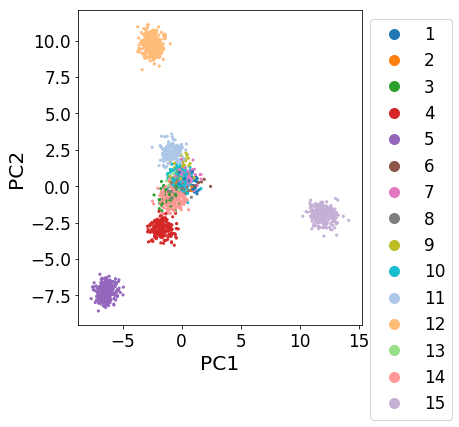

In [46]:
scprep.plot.scatter2d(data_pca, c=metadata['group'], legend_anchor=(1,1), figsize=(6.6,6))

#### Create a bar graph showing the number of cells per cluster

In [47]:
groups,counts = np.unique(metadata['group'], return_counts=True)

Text(0, 0.5, 'Cells in Group')

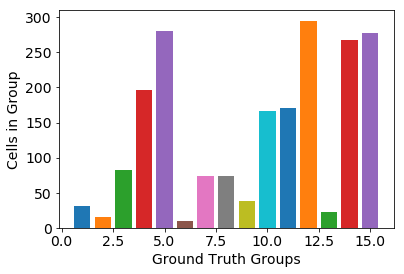

In [48]:
fig, ax = plt.subplots(1)
for g, c in zip(groups, counts):
    ax.bar(g,c)
ax.set_xlabel('Ground Truth Groups')
ax.set_ylabel('Cells in Group')

### Calculating Silhouette Score

The silhouette is a measure of fit for a given set of cluster assignments and dataset. The silhouette score calculates the ratio between the average intra-cluster distance and inter-cluster distances. This score is often calculated over a various numbers of clusters, and the maximum is chosen for clustering. Values close to 1 are good.  Values close to -1 are bad. This measure is calculated over different `n_clusters` values, and the setting with the highest score is the recommended number of clusters.



This measure is really only useful for methods where `n_clusters` is set by the user, so we'll focus on `KMeans` and `SpectralClustering` for this section.

More information on this score can be found in the `sklearn` user guide: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient.

#### Clustering with `KMeans` 

The silhouette score is most often used with 

In [49]:
# KMeans
kmeans_clusters = {}

for n_clusters in range(2,20):
      kmeans_clusters[n_clusters] = cluster.KMeans(n_clusters=n_clusters).fit_predict(data)

In [50]:
scores = []
for n_clusters in range(2,20):
    scores.append(sklearn.metrics.silhouette_score(data, kmeans_clusters[n_clusters] ))

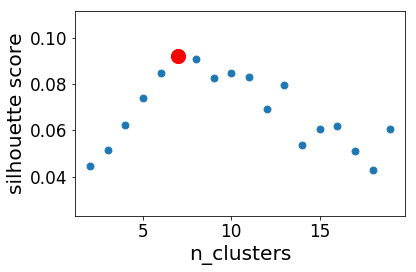

In [51]:
ax = scprep.plot.scatter(range(2,20), scores, xlabel='n_clusters', ylabel='silhouette score')

# Plot the largest value in red
ix_max = np.argmax(scores)
scprep.plot.scatter(2 + ix_max, scores[ix_max], c='red', ax=ax)

### Plotting the clusters

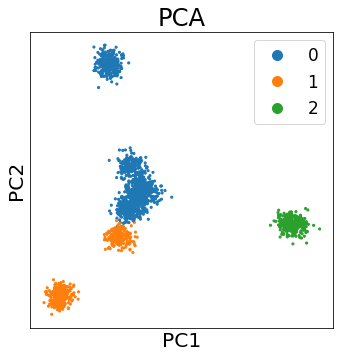

In [52]:
clusters = kmeans_clusters[3]


ax = scprep.plot.scatter2d(data_pca, c=clusters,
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5.2))

ax.figure.tight_layout() 

#### Discussion

In pairs, take turns adjusting:
1. The number of clusters generated  
2. The distance between each cluster 
3. The clustering algorithm from `KMeans` to `SpectralClustering` (in the code block where `sklearn.cluster.KMeans` is called)

Identify:
1. A set of parameters where the silhouette score perfectly indicates the correct number of clusters
2. A set of parameters where the silhouette score fails to indicate the correct number of clusters
3. Does `KMeans` or `SpectralClustering` produce better silhouette scores?

# BONUS: Clustering trajectories

Clustering is all about partitioning data. That means that even if data is continuous, you might want to use clustering to differentiate between different regions of the data. Here, the idea of a true number of clusters breaks down because observations are not distributed as a centroid + noise. 

However, it is not objectionable to think that there are "good" clusterings of a dataset and "less good" ones. For example, if two branches of a dataset are grouped together, that's less than ideal.


In [35]:
# Run Splatter

# You can easily change the number of paths and cells here
n_paths = 3
cells_per_path = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=cells_per_path * n_paths, 
                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000,
                        de_down_prob=0.5,
                        path_from=[0,0,0],
                        mean_shape=1,
                        seed=0)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [36]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int}) # These are strings by default, but we want ints

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

# Computing PCA
data_pca = scprep.reduce.pca(data)

### Plotting the ground truth

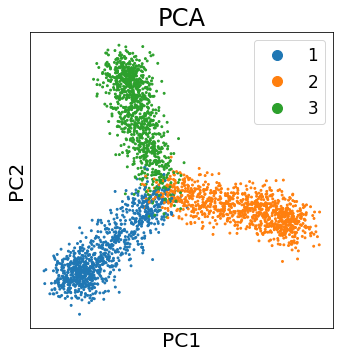

In [37]:
ax = scprep.plot.scatter2d(data_pca, c=metadata['group'],
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5.2))

ax.figure.tight_layout()

In [38]:
# KMeans
kmeans_clusters = {}

for n_clusters in range(2,10):
      kmeans_clusters[n_clusters] = cluster.KMeans(n_clusters=n_clusters).fit_predict(data)

In [39]:
scores = []
for n_clusters in range(2,10):
    scores.append(sklearn.metrics.silhouette_score(data, kmeans_clusters[n_clusters] ))

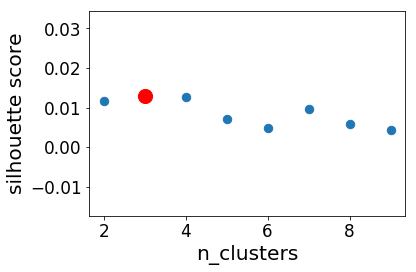

In [41]:
ax = scprep.plot.scatter(range(2,10), scores, xlabel='n_clusters', ylabel='silhouette score')

# Plot the largest value in red
ix_max = np.argmax(scores)
scprep.plot.scatter(2 + ix_max, scores[ix_max], c='red', ax=ax)

### Plotting the clusters

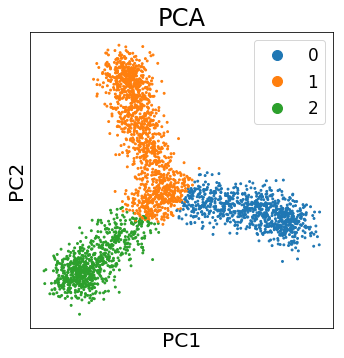

In [42]:
clusters = kmeans_clusters[3]


ax = scprep.plot.scatter2d(data_pca, c=clusters,
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5.2))

ax.figure.tight_layout() 